In [ ]:
!pip install scikit-image
!pip install --upgrade sympy

Using device: cuda


Saving Screenshot 2025-04-21 011849.png to Screenshot 2025-04-21 011849.png
Please upload a style image as well.


Saving Screenshot 2025-04-20 225845.png to Screenshot 2025-04-20 225845.png


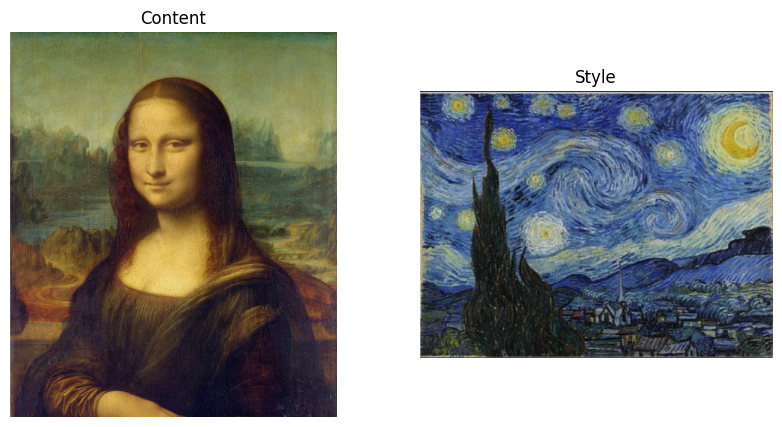

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 159MB/s] 


Starting optimization...


  0%|          | 0/1000 [00:00<?, ?it/s]

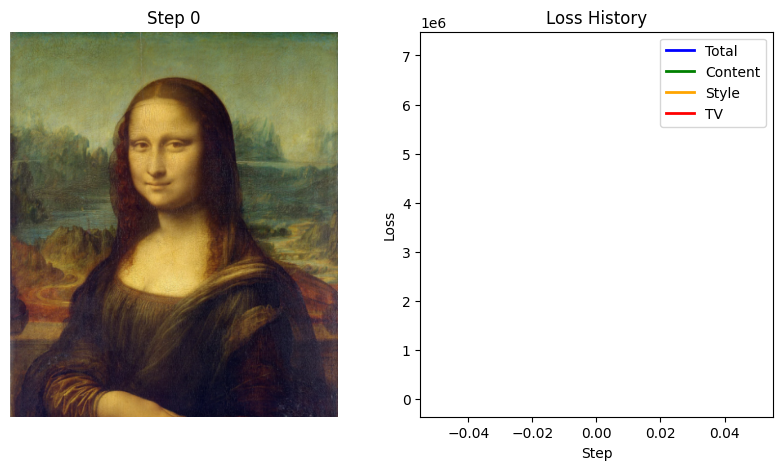

 20%|██        | 200/1000 [00:20<01:19, 10.03it/s]

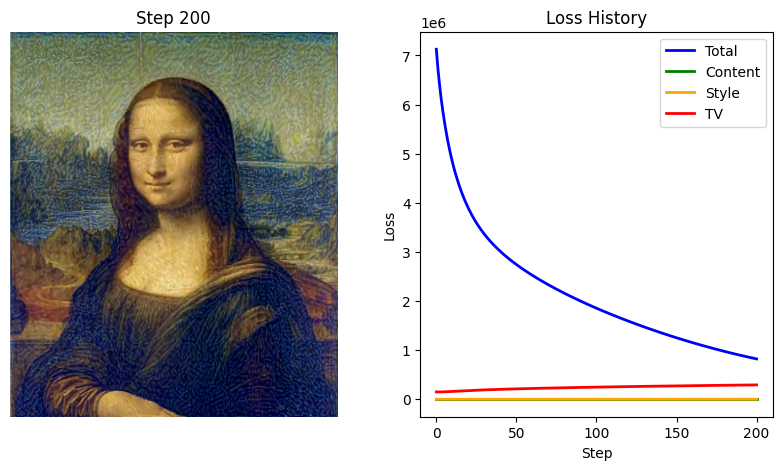

 40%|████      | 400/1000 [00:41<01:01,  9.71it/s]

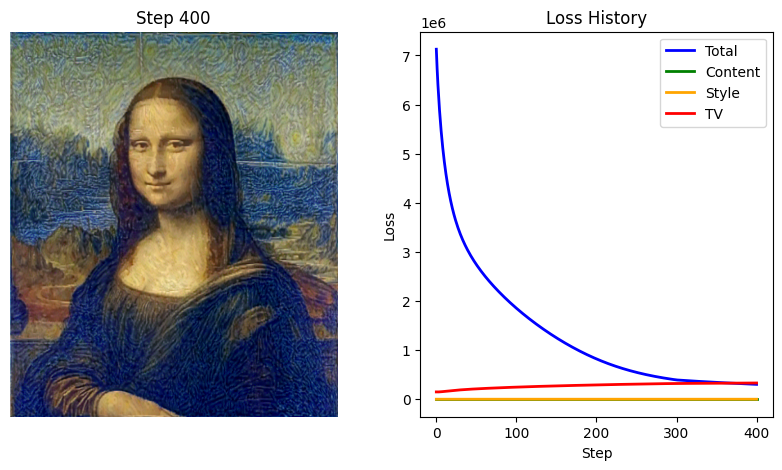

 60%|██████    | 600/1000 [01:02<00:43,  9.20it/s]

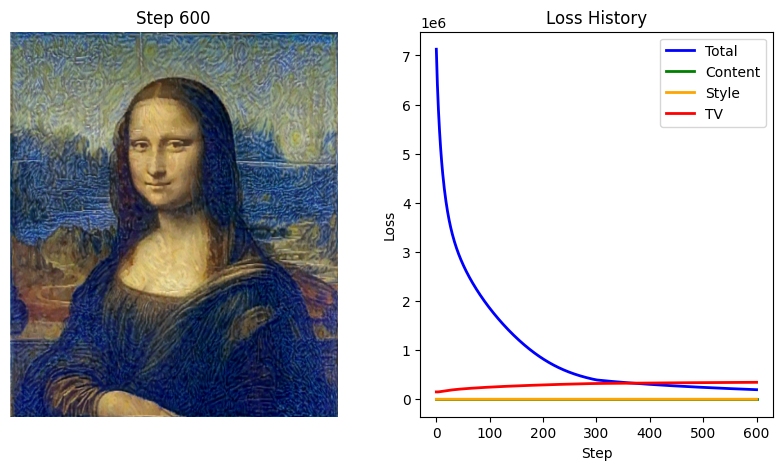

 80%|████████  | 800/1000 [01:24<00:22,  9.01it/s]

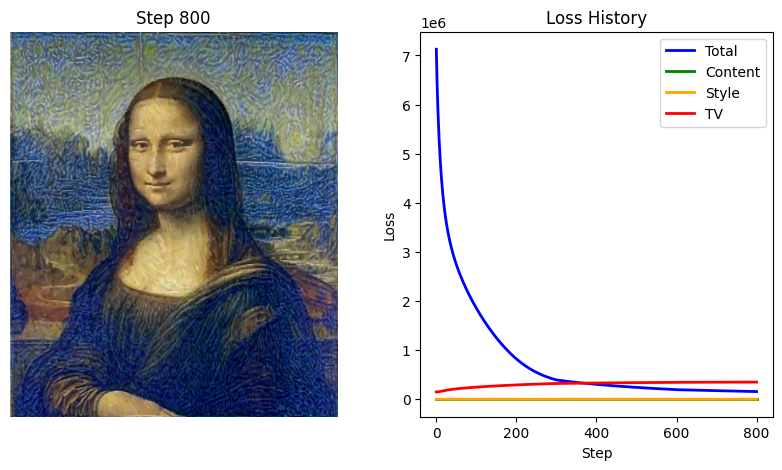

100%|█████████▉| 999/1000 [01:47<00:00,  9.22it/s]

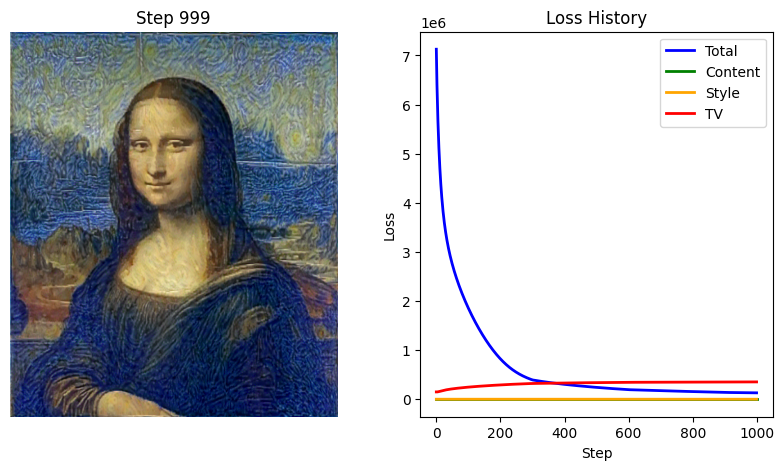

100%|██████████| 1000/1000 [01:47<00:00,  9.28it/s]


Final Loss Values:
Total Loss: 129888.078125
Content Loss: 4.233898162841797
Style Loss: 1.2988349199295044
TV Loss: 352558.5


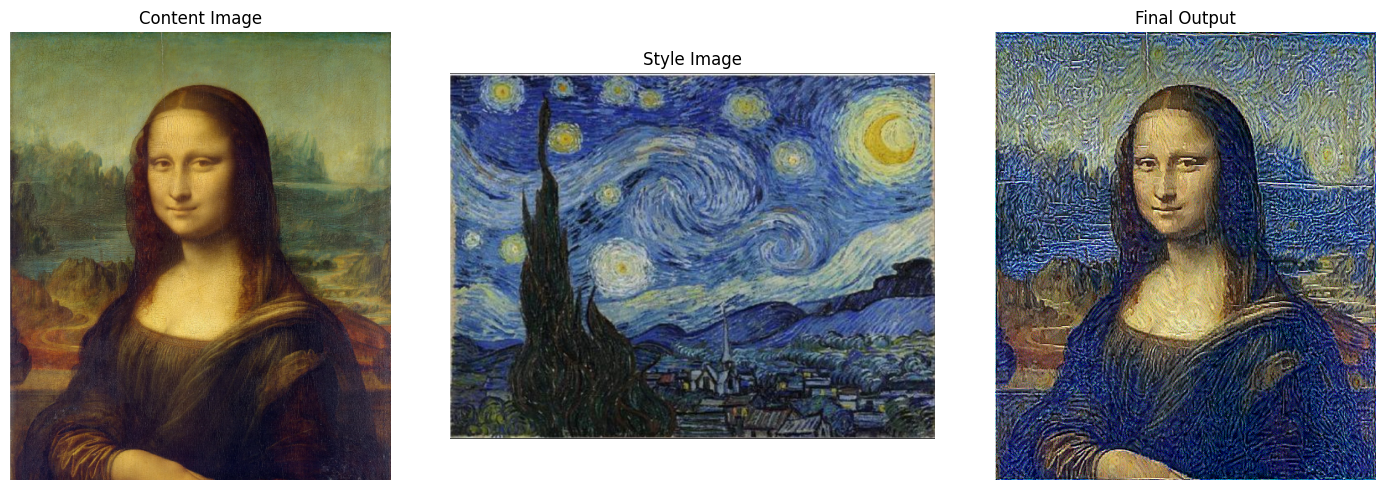

Saved as refined_photorealistic_output.jpg


In [ ]:
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import cv2

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Helper functions
def load_image(image_path, max_size=512, shape=None):
    image = Image.open(image_path).convert('RGB')
    size = max_size if max(image.size) > max_size else max(image.size)
    if shape:
        size = shape
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
    ])
    image = in_transform(image).unsqueeze(0)
    return image.to(device)

def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + \
            np.array((0.485, 0.456, 0.406))
    return np.clip(image, 0, 1)

def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    return torch.mm(tensor, tensor.t())

# VGG mapping
VGG_LAYER_MAP = {
    'block1_conv1': '0',
    'block1_conv2': '2',
    'block2_conv1': '5',
    'block2_conv2': '7',
    'block3_conv1': '10',
    'block3_conv2': '12',
    'block3_conv3': '14',
    'block3_conv4': '16',
    'block4_conv1': '19',
    'block4_conv2': '21',
    'block5_conv1': '28',
}

custom_layers = {
    VGG_LAYER_MAP['block1_conv1']: 'conv1_1',
    VGG_LAYER_MAP['block2_conv1']: 'conv2_1',
    VGG_LAYER_MAP['block3_conv1']: 'conv3_1',
    VGG_LAYER_MAP['block4_conv1']: 'conv4_1',
    VGG_LAYER_MAP['block5_conv1']: 'conv5_1',
    VGG_LAYER_MAP['block4_conv2']: 'conv4_2',
}

def get_features(image, model, layers):
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# Style Transfer Function
def photorealistic_style_transfer(content_path, style_path,
                                 num_steps=1000,
                                 content_weight=1e0,
                                 style_weight=1e5,
                                 tv_weight=1e-6,
                                 max_size=512,
                                 show_every=50):
    vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()
    for param in vgg.parameters():
        param.requires_grad_(False)

    content = load_image(content_path, max_size=max_size)
    style = load_image(style_path, shape=content.shape[-2:])
    target = content.clone().requires_grad_(True)

    content_features = get_features(content, vgg, custom_layers)
    style_features = get_features(style, vgg, custom_layers)
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

    optimizer = optim.Adam([target], lr=0.005)
    scheduler = StepLR(optimizer, step_size=300, gamma=0.5)

    loss_history = {"total": [], "content": [], "style": [], "tv": []}

    print('Starting optimization...')
    for i in tqdm(range(num_steps)):
        def closure():
            optimizer.zero_grad()
            target_features = get_features(target, vgg, custom_layers)
            content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

            style_loss = 0
            for layer in style_grams:
                target_feature = target_features[layer]
                target_gram = gram_matrix(target_feature)
                _, d, h, w = target_feature.shape
                style_gram = style_grams[layer]
                layer_style_loss = torch.mean((target_gram - style_gram) ** 2) / (d * h * w)
                style_loss += layer_style_loss / len(style_grams)

            tv_loss = torch.sum(torch.abs(target[:, :, :, :-1] - target[:, :, :, 1:])) + \
                      torch.sum(torch.abs(target[:, :, :-1, :] - target[:, :, 1:, :]))

            loss = content_weight * content_loss + style_weight * style_loss + tv_weight * tv_loss
            loss.backward()

            loss_history["total"].append(loss.item())
            loss_history["content"].append(content_loss.item())
            loss_history["style"].append(style_loss.item())
            loss_history["tv"].append(tv_loss.item())

        optimizer.step(closure)
        scheduler.step()

        if (i % show_every == 0) or (i == num_steps - 1):
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(im_convert(target))
            plt.title(f'Step {i}')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.plot(loss_history["total"], label='Total', color='blue', linewidth=2)
            plt.plot(loss_history["content"], label='Content', color='green', linewidth=2)
            plt.plot(loss_history["style"], label='Style', color='orange', linewidth=2)
            plt.plot(loss_history["tv"], label='TV', color='red', linewidth=2)
            plt.legend()
            plt.title('Loss History')
            plt.xlabel('Step')
            plt.ylabel('Loss')
            plt.show()

        # Final Output Comparison (Content, Final, Sharpened)
    print("Final Loss Values:")
    print(f"Total Loss: {loss_history['total'][-1]}")
    print(f"Content Loss: {loss_history['content'][-1]}")
    print(f"Style Loss: {loss_history['style'][-1]}")
    print(f"TV Loss: {loss_history['tv'][-1]}")


    return target

# Upload images
from google.colab import files
uploaded = files.upload()

if len(uploaded) == 1:
    content_path = list(uploaded.keys())[0]
    print("Please upload a style image as well.")
    uploaded = files.upload()
    style_path = list(uploaded.keys())[0]
else:
    content_path = list(uploaded.keys())[0]
    style_path = list(uploaded.keys())[1]

# Show uploaded images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(Image.open(content_path))
plt.title("Content")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(Image.open(style_path))
plt.title("Style")
plt.axis("off")
plt.show()

# Run style transfer
output = photorealistic_style_transfer(content_path, style_path, num_steps=1000, show_every=200)

# Final Output Comparison (Content, Final, Sharpened)
final_output = im_convert(output)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(Image.open(content_path))
plt.title("Content Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(Image.open(style_path))
plt.title("Style Image")
plt.axis("off")


# Sharpening
output_np = (final_output * 255).astype('uint8')
kernel_sharpen = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])
sharpened_output = cv2.filter2D(output_np, -1, kernel_sharpen)
sharpened_output = sharpened_output / 255.0

plt.subplot(1, 3, 3)
plt.imshow(sharpened_output)
plt.title("Final Output")
plt.axis("off")
plt.tight_layout()
plt.show()

# Save sharpened result
sharpened_image = Image.fromarray((sharpened_output * 255).astype('uint8'))
sharpened_image.save("refined_photorealistic_output.jpg")
print("Saved as refined_photorealistic_output.jpg")

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import cv2

# Convert images to grayscale
def to_grayscale_np(image):
    return cv2.cvtColor((image * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)

# Resize original content image to match output size
content_img = Image.open(content_path).convert("RGB").resize((final_output.shape[1], final_output.shape[0]))
content_np = np.array(content_img) / 255.0

# Ensure all images are in grayscale
content_gray = to_grayscale_np(content_np)
final_gray = to_grayscale_np(final_output)
sharp_gray = to_grayscale_np(sharpened_output)

# Compute metrics
ssim_final = ssim(content_gray, final_gray)
psnr_final = psnr(content_gray, final_gray)

ssim_sharp = ssim(content_gray, sharp_gray)
psnr_sharp = psnr(content_gray, sharp_gray)

# Print the results
print("\n--- Image Quality Metrics ---")
print(f"Content vs Final Output -> SSIM: {ssim_final:.4f}, PSNR: {psnr_final:.2f} dB")
print(f"Content vs Sharpened Output -> SSIM: {ssim_sharp:.4f}, PSNR: {psnr_sharp:.2f} dB")


--- Image Quality Metrics ---
Content vs Final Output -> SSIM: 0.6213, PSNR: 25.53 dB
Content vs Sharpened Output -> SSIM: 0.3154, PSNR: 17.89 dB
